# Exercise 3

In this assignment, you will find numerical solutions to the diffusion equation. In particular, you will use an implicit method, and consider problems with both Dirichlet and Neumann boundary conditions.

**Remember**
   * You are expected to use numpy and scipy libraries where appropriate.  
   * You should run each cell in order from the top of the notebook; there is no need to repeat code between cells
   * Use the "refresh kernel" button to reset everything and start again
   * Make sure your notebook runs fully & without errors, from a fresh kernel, before submitting it

## Problem Overview

The 1D diffusion equation is :

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2}$$

You should discretize this equation onto $N_x$ space points, with separation $\Delta x = h$, and into timesteps $\Delta t = \tau$.  In the equations below, I use subscript $i$ as a space index, and superscript $n$ for time indices.

Having discretized the problem, you should use the _implicit_ finite difference equation, as discussed in lectures :

$$\frac{u_i^{n+1} - u_i^n}{\tau} = k \frac{u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}}{h^2}$$

This can be written in matrix form $u^n = M u^{n+1}$ using :

$$u_i^n = - \alpha u_{i-1}^{n+1} + (1 + 2\alpha) u_i^{n+1} - \alpha u_{i+1}^{n+1}$$

where $\alpha = \frac{k \tau}{h^2}$.

In the problems below, you are asked to solve the diffusion equation in the context of the heat equation. Here, $k$ is the thermal diffusivity, given by $k = \frac{\lambda}{\rho C}$, where $\lambda$ is the thermal conductivity, $\rho$ is the density, and $C$ is the specific heat capacity. The questions below concern an iron poker of length 50cm.  You may take the thermal conductivity of iron to be a constant 59 W/m/K, its specific heat as 450 J/kg/K, and its density as 7,900 kg/m3.  You can ignore heat loss along the length of the poker.


## Part 1 - Dirichlet rod_rod_rod_boundary Conditions

The poker is initially in equilibrium, at room temperature of 20 C. At time $t = 0$, one end is thrust into a furnace at 1000 C and the other end is held in an ice bath at 0 C. Your task is to calculate the temperature distribution along the poker as a function of time.

The fact that the ends of the rod are held at fixed temperatures of 0 C and 1000 C corresponds to a Dirichlet boundary condition.  These can be included in the implicit method as follows.

The implicit finite difference equation, above, will allow us to calculate the unknown 'internal' nodes, ie. $0 < i < (N_x-1)$.  However, the boundary nodes, $i=0, N_x$, must have fixed values $d_0, d_N$.  To fix the boundaries, we take the matrix M to be of size $(N_x-2) \times (N_x-2)$, and adding a vector term :

$$u^n = Mu^{n+1} + b$$

For $N_x = 7$ (for example), this gives :

$$M = \begin{pmatrix}
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+2\alpha & \\
\end{pmatrix}$$

$$b = \begin{pmatrix}
-\alpha d_0 \\
0 \\
0 \\
0 \\
-\alpha d_N \\
\end{pmatrix}$$

You can show this gives the required finite equation for $i=1, (N-1)$, eg. :

$$u^n_1 = - \alpha u^{n+1}_2 + (1 + 2\alpha)u^{n+1}_1 - \alpha d_0$$

First, write functions that will construct the matrix equation and boundary value term.

In [1]:
%matplotlib notebook
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm, animation


class Diffusion:
    def __init__(self,x,seg,dt,d0,dN,u0,k,shape):
        '''Initialise class for material
        
        x - rod length;
        seg - no. segments to divide rod into;
        dt - time step between iterations;
        d0 - x0 Dirichlet boundary condition;
        dN - xN Dirichlet boundary condition;
        u0 - initial rod temperature;
        k - thermal diffusivity, calcuated by: thermal conductivity / density*specific heat
        shape - 0 for rod, 1 for square plate'''

        self.x = x
        self.k=k
        self.seg=seg
        self.dt=dt
        self.step=x/seg
        self.d0 = d0
        self.dN = dN
        self.u0 = u0
        self.a = (k * dt) / self.step**2
        if shape == 0:
            self.u = np.full((seg - 2), u0)
        elif shape == 1:
            self.u = np.full(((seg),(seg)), u0)        
        self.shape = shape
        
    def matmaker(self, b_type):
        '''initialise matrix for given problem
        
        b_type - 0 for Dirichlet problem (part 1), 1 for Neumann problem (part 2)'''

        if self.shape == 0: #Setup for 1D problem
            mat = np.full((self.seg -2 ,self.seg - 2),(-self.a))
            for i in range(0,len(mat[:,0])):
                mat[i,i]=1 + 2*self.a

        elif self.shape == 1: #Setup for 2D problem
            mat = np.full((self.seg, self.seg),(-self.a))
            for i in range(0,len(mat[:,0])):
                mat[i,i] = 1 + 2*self.a
                mat[-1,-1] = 1 + self.a
                
        mat = np.tril(np.triu(mat,-1),1) # Clear off diagonal terms
        
        if b_type != 0: #enact Neumann condition
            mat[0,0] = 1 + self.a

        return mat

    def boundary(self,b_type):
        '''set boundary condition vector for given problem
        
        b_type - 0 for Dirichlet problem (part 1), 1 for Neumann problem (part 2)'''

        if self.shape == 0: #setup for 1D problem
            vect=np.zeros(self.seg - 2)
            
            if b_type == 0: #Dirichlet condition task
                vect[0] = -self.a * self.d0

            vect[-1] = -self.a * self.dN #Rod end kept in heat for both task setups
        
        elif self.shape == 1: #setup for 2D problem
            vect = np.zeros((self.seg,self.seg))
            if b_type == 1:
                vect[round(self.seg/2),round(self.seg/2)] = -self.a * self.dN #Place heat in centre of plate

        return vect
    
    def iterator(self, u, ident):
        return (linalg.solve( self.mat,(u - self.bound)) + (u - self.bound) @ linalg.inv(self.mat)
                               - linalg.solve(ident,(u - self.bound)))
    
    def plotter(self,f_u,timesteps):
        '''plot 3D graph of heat distribution over time
        
        Args:
        f_u - array holding u(x,t) data;
        timesteps - no. iterations performed'''

        xr = np.arange(0,self.seg - 2,1)
        if self.shape == 0:
            yr = np.arange(0,timesteps,1)*self.dt

        elif self.shape == 1:
            yr = xr

        X,Y = np.meshgrid(xr,yr)
        X = X/(np.amax(X)) * self.x

        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.plot_surface(X, Y, f_u, vmin=f_u.min() * 2, cmap=cm.hot)
        ax.set_xlabel('Position (m)')
        ax.set_ylabel('Time (s)')
        ax.set_zlabel('Temperature (K)')
        
        if self.k == 1.659634317862166e-05:
            plt.title('Iron Rod')
            
        elif self.k == 0.00011624536178107607:
            plt.title('Copper Rod')
        
        plt.show()
        
        return ax.plot_surface(X, Y, f_u, vmin=f_u.min() * 2, cmap=cm.hot)
    
    def plot2D(self,timesteps):
        '''Function to plot an animated 3D graph for the variance of temperature by position and time
        
        timesteps - no. iterations used to calculate the plotting data'''

        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")

        def anifunc(step):
            '''Function to iterate over the temperature data and return plots for the animation function'''
            
            xr = np.arange(0, self.seg, 1)
            yr = xr

            X,Y = np.meshgrid(xr,yr)
            X = X/(np.amax(X)) * self.x
            Y = Y/(np.amax(Y)) * self.x
            Z = self.f_u[step,:,:]

            ax.set(xlim3d=(0, self.seg), xlabel='X') #set limits to reduce computation load
            ax.set(ylim3d=(0, self.seg), ylabel='Y')
            ax.set(zlim3d=(0, 1300), zlabel='Z')

            ax.clear()
            ax.set_xlabel('x position (m)')
            ax.set_ylabel('y position (m)')
            ax.set_zlabel('Temperature (K)')
            ax.plot_surface(X, Y, Z, rstride=2, cstride=2, cmap = cm.hot)

        ani = animation.FuncAnimation(fig, anifunc, 100, interval=50)
        return ani
    
    def time_iterator(self, timesteps, b_type):
        '''find temp distribution by time
        
        Args: 
        timesteps - no. time steps;
        b_type - Boundary conditions: 0 for Dirichlet conditions (part 1), 1 for Neumann (part 2)
        '''

        self.mat = mat = self.matmaker(b_type) #use function to generate matrix based on specified boundary conditions
        self.bound = bound = self.boundary(b_type) #generate specified boundary condition vector

        if self.shape == 0:

            f_u = np.zeros((timesteps, self.seg - 2)) #initialise storage array for u(x,t)
            f_u [0,:] = linalg.solve(mat,(self.u - bound)) #initialise first column for iterating

            for i in range(1,timesteps): #iterate until equilibrium or timestep limit reached

                f_u[i,:] = linalg.solve(mat ,(f_u[i-1,:] - bound))

                if i > 10 and np.mean(f_u[i,:] - f_u[i-10,:]) < 0.01: #check if rod has reached equilibrium and finish iterating

                    timesteps = i #store final number of iterations
                    f_u = f_u[0:i,:] #remove surplus empty storage matrix columns

                    break
                
            self.plotter(f_u, timesteps) #send rod temperature data and no. iterations to plotting function
            
        elif self.shape == 1:
            
            steps2d = 2000
            f_u = np.zeros((steps2d, self.seg, self.seg)) #initialise storage array for u(x,t)
            ident = np.diag(np.ones(self.seg)) #

            f_u[0,:,:] = self.iterator(self.u ,ident)#(linalg.solve(mat,(self.u - bound)) + linalg.solve(mat, np.transpose(self.u - bound)) #generate first time step
                           #- linalg.solve(ident,(self.u - bound)))
            
            for j in range(1,steps2d): #iterate until timestep limit reached
                f_u[j,:,:] = self.iterator(f_u[j-1,:,:], ident) #(linalg.solve(mat,(f_u[j-1,:,:] - bound)) + (f_u[j-1,:,:] - bound) @ linalg.inv(mat)
                #                - linalg.solve(ident,(f_u[j-1,:,:] - bound)))
                
            self.f_u = f_u
            
            return self.plot2D(steps2d)



segments = 100 #no. nodes to split the rod into (dictates no of nodes per side for 2D plate)

timesteps = 50000 #maximum number of iterations performed
dt = 1 #change in time between iterations

x = 0.5
d0 = 273
dN = 1273
u0 = 293

'''material data'''
iron_tc = 59
iron_density = 7900
iron_shc = 450
iron_tdiff = iron_tc / (iron_density * iron_shc) #Iron thermal diffusion

cu_tc = 401
cu_density = 8960
cu_shc = 385
cu_tdiff = cu_tc / (cu_density * cu_shc) #copper thermal diffusion

'''initialise material classes'''
iron_50 = Diffusion(x,segments,dt,d0,dN,u0,iron_tdiff,0)
cu_50 = Diffusion(x, segments, dt, d0, dN, u0, cu_tdiff,0)

iron_plate = Diffusion(x, 25, dt, d0, dN, u0, iron_tdiff,1)
copper_plate = Diffusion(x, 25, dt, d0, dN, u0, cu_tdiff,1)

Now write a function which will transport the temperature distribution at time step $n$ to time step $n+1$. You will need to use an appropriate linear algebra routine.

Finally, use the functions above to calculate the temperature distribution as a function of time, and display this graphically using an appropriate plotting routine.

<IPython.core.display.Javascript object>


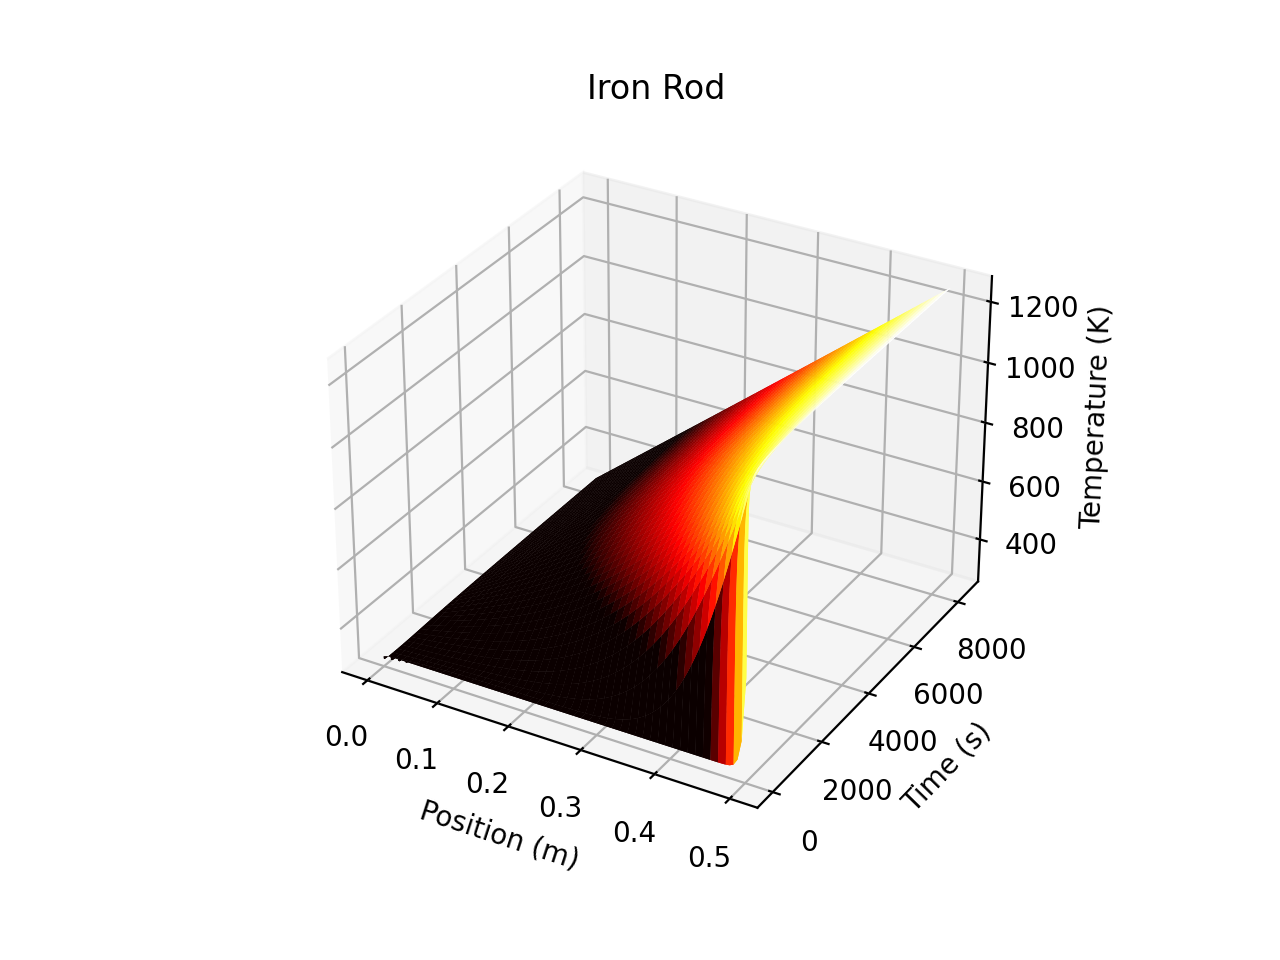

<IPython.core.display.Javascript object>


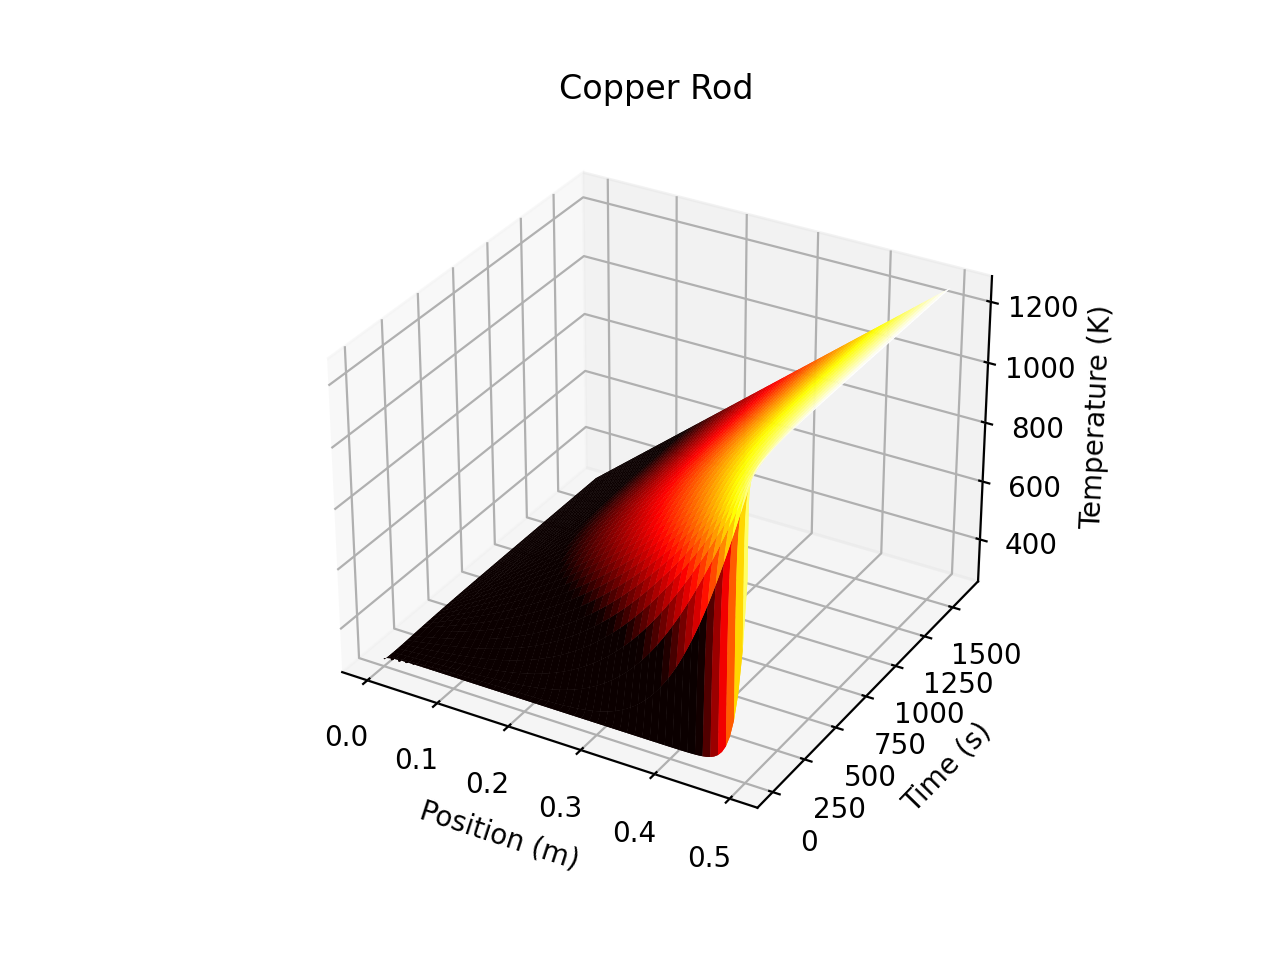

In [2]:
'''Rods with Dirichlet boundary conditions'''
iron_50.time_iterator(timesteps, 0)
cu_50.time_iterator(timesteps, 0)

## Part 2 - Neumann Boundary Conditions

Now we assume the far end of the poker from the furnace is no longer held at 0 C, but instead experiences no heat loss. Again your task is to find the temperature distribution as a function of time.

In this case, you will need to implement a Neumann boundary condition at the end of the poker, to ensure the derivative $\frac{\partial u}{\partial x}$ is zero. Since we are using finite differences, this is equivalent to ensuring the final two nodes have the same value.

The finite difference equation for node $i=(N-1)$ is :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + 2\alpha)u^{n+1}_{N-1} - \alpha u^{n+1}_{N}$$

To enforce the Neumann boundary condition we can substitute $u^{n+1}_{N} = u^{n+1}_{N-1}$, giving :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + \alpha)u^{n+1}_{N-1}$$

This results in a modified form of $M$, shown here for the example $N_x=7$, and the matrix ix $5\times5$ :  

$$M = \begin{pmatrix}
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+\alpha & \\
\end{pmatrix}$$

Note that you will also need to include a boundary term vector $b$, since the end of the poker in the furnace still requires a Dirichlet condition.

First write any new functions you need. You should be able to re-use some functions from Part 1.

Finally, use the functions above to calculate the temperature distribution as a function of time, and display this graphically using a sensible plotting function.

<IPython.core.display.Javascript object>


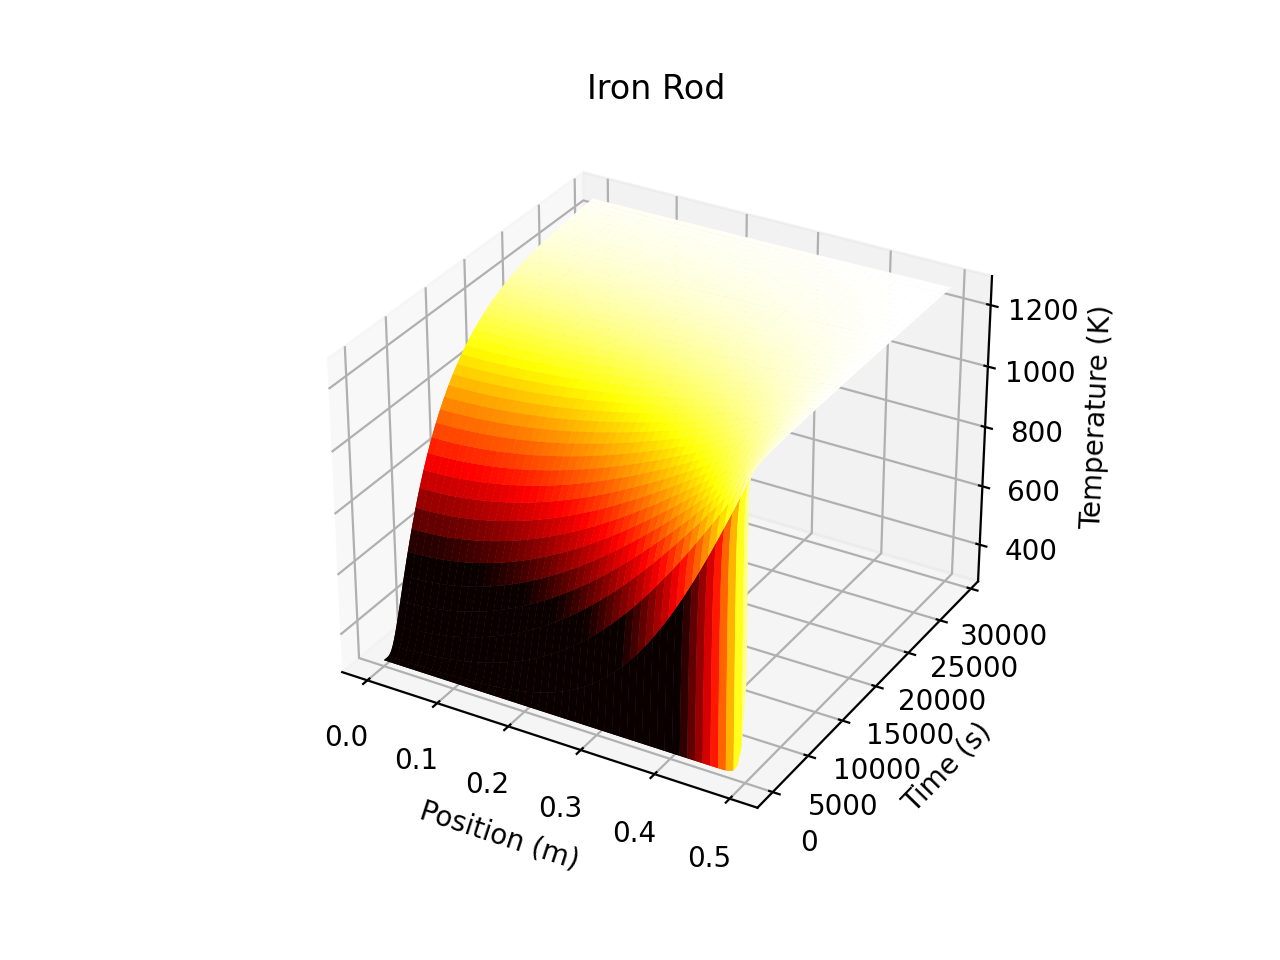

<IPython.core.display.Javascript object>


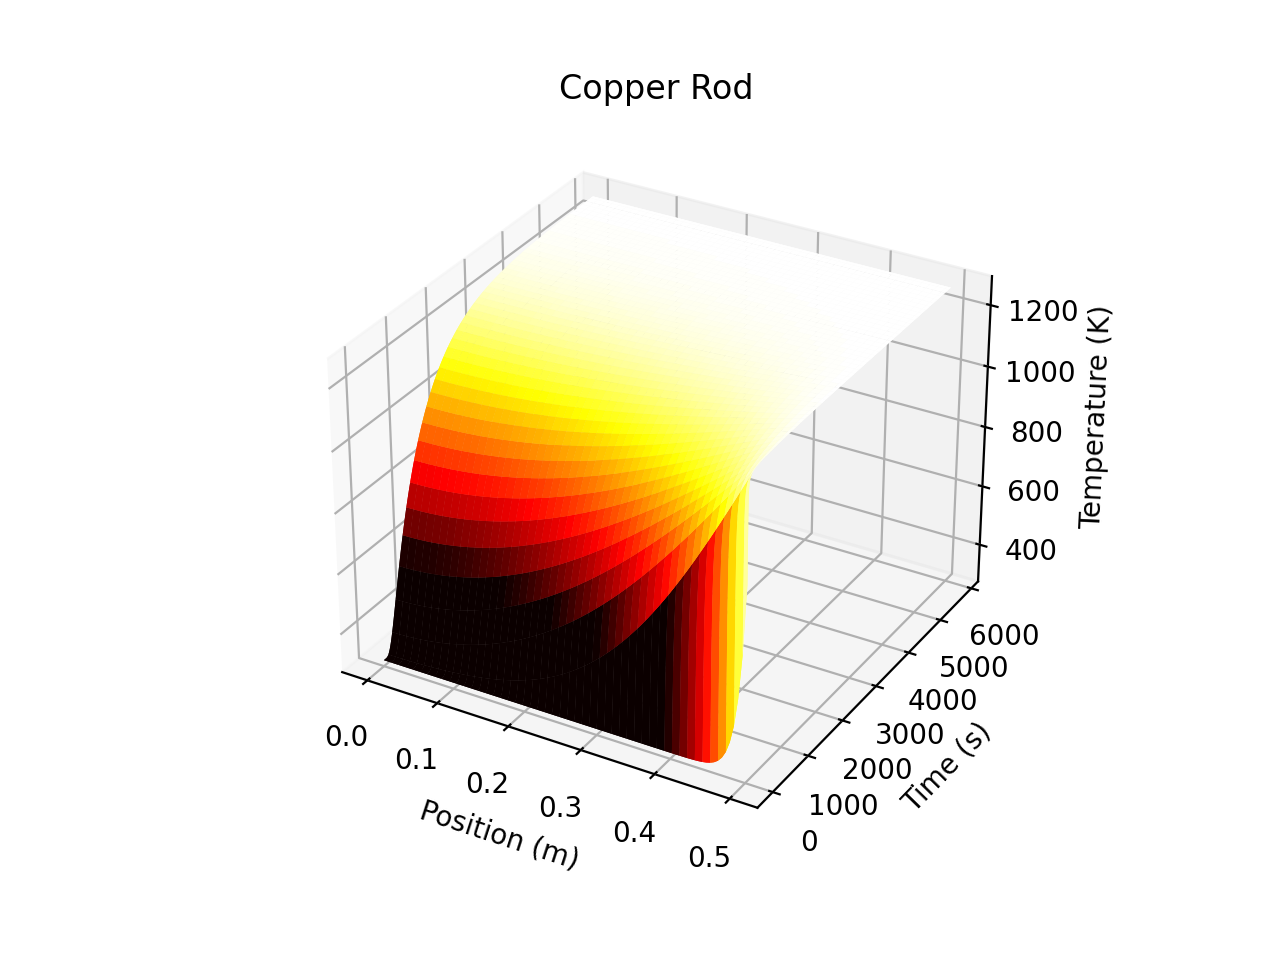

In [3]:
'''Rods with Neumann boundary conditions'''
iron_50.time_iterator(timesteps, 1)
cu_50.time_iterator(timesteps, 1)

<IPython.core.display.Javascript object>


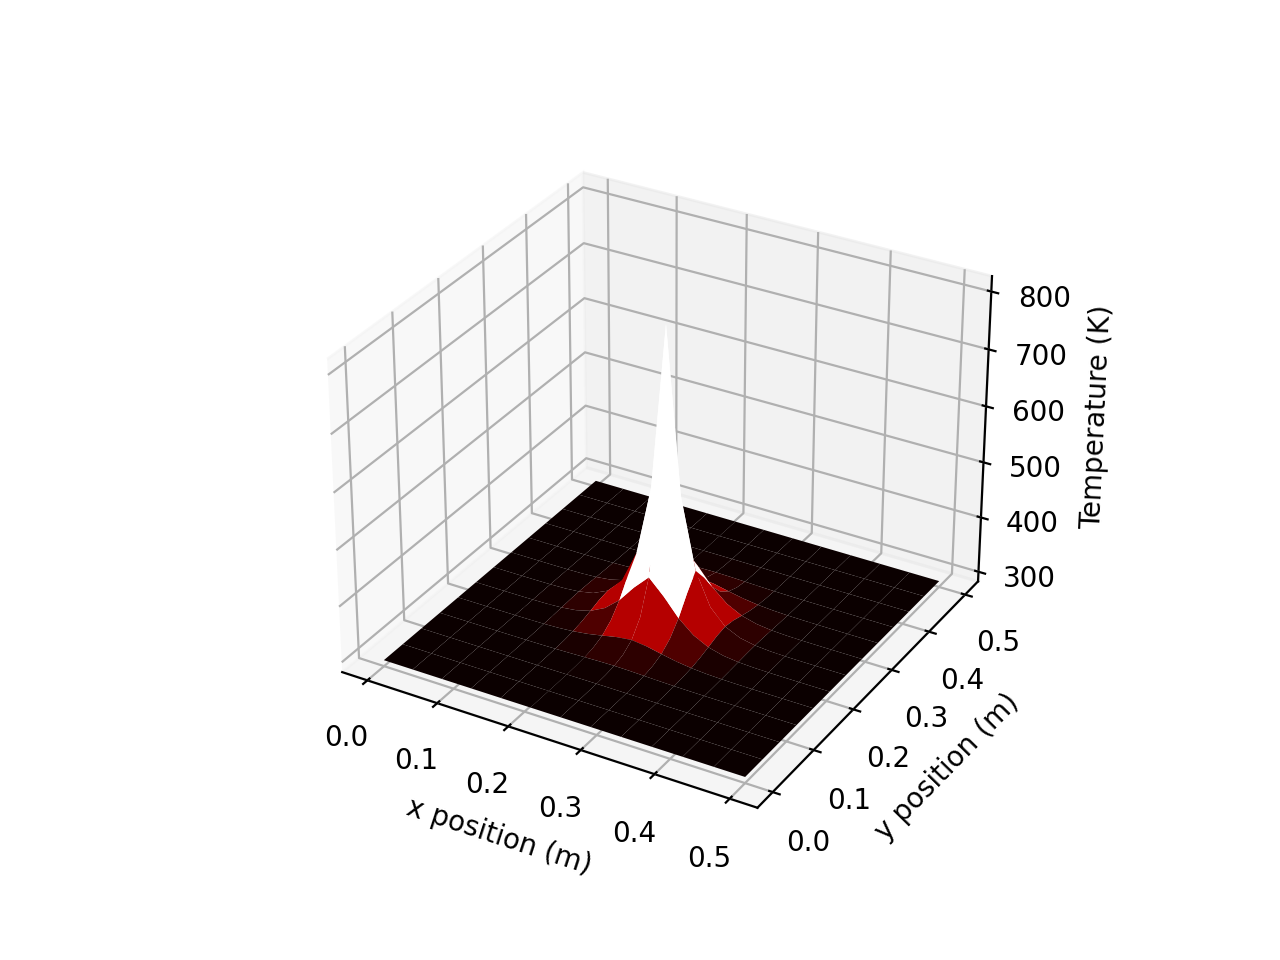

<IPython.core.display.Javascript object>


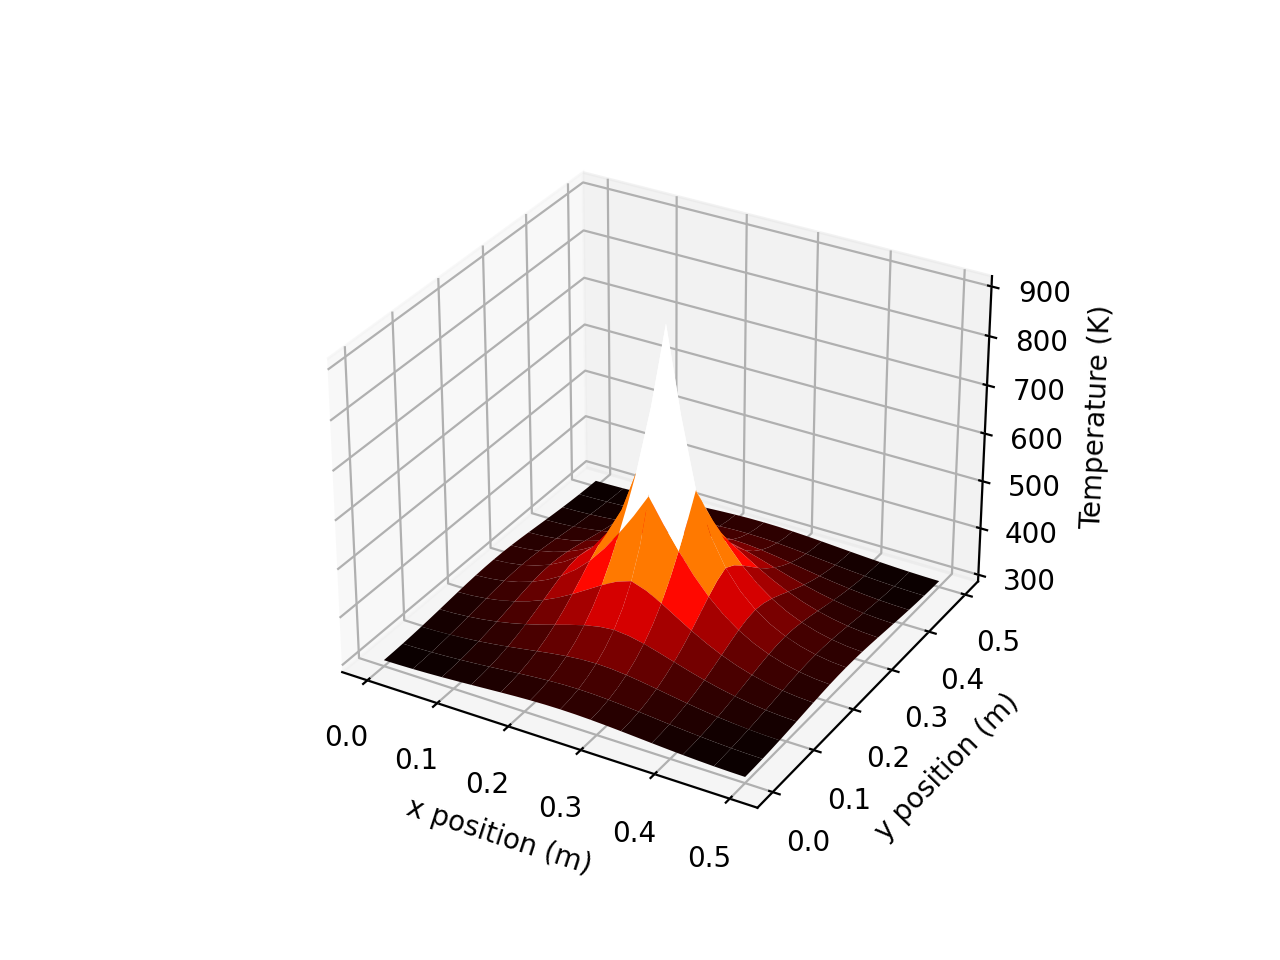

In [4]:
'''2D Plates heated in centre, comment out to improve performance'''
ironani = iron_plate.time_iterator(timesteps, 1)
copperani = copper_plate.time_iterator(timesteps, 1)

# Part 3

In the Markdown cell below, describe how your code solves the problem set. State any equations used in the solution and how they were obtained. Include your reasons for any libraries you used, as well as any particular programming techniques. Explain your choice of any test cases. Finally, state any salient features of the results you obtained. You are not expected to write more than about 250-300 words.

My script uses the equations provided at the beginning of the exercise to set up and utilise matrices to solve a system of linear equations relating to the diffusion of heat through metal objects.

The script does this by using the generated equation matrix for the implicit forward time centred space equation and rearranging for 

$u^{n+1} = M^{-1} (u^n - b)$ 

This is then calculated using the Scipy linalg.solve() method which performs the required matrix inversion on $M$ and then performs the rest of the equation. This method is faster than the explicit forward time centred space method and is unconditionally stable. 

The script utilises a check on the mean difference between subsequent iterations to test for equilibrium and break the loop in order to reduce computation time and provide more useful results. This has been chosen to be a difference in means of >0.05, corresponding to a very small rate of change and a good approximation to the equilibrium state of the system. For the Dirichlet task this shows a linear temperature gradient from 0&deg;C to 1000&deg;C whilst for the Neumann task the temperature across the rod until equilibrium is reached at a constant 1000&deg;C for the entire rod. 

For the 2D case the equation utilised is

$u^n_{i,j} = u^{n+1}_{i,j} + \alpha(u^{n+1}_{i-1,j} - 2u^{n+1}_{i,j} + u^{n+1}_{i+1,j} + u^{n+1}_{i,j-1} - 2u^{n+1}_{i,j} + u^{n+1}_{i,j+1})$

where alpha is $\alpha = \frac{k \tau}{h^2}$ and $h^2 = (\Delta x)^2 = (\Delta y)^2$ (due to the symmetrical placement of nodes on a square grid)

This is perfomed by using linalg.solve() for the x direction in the same way as for the rod whilst for the y direction I checked by hand and found that the operation $(u^n_{i,j} - b) M^{-1}$ returned the correct nodes for the y direction as long as a correction was made for the double counting of the $u^n_{i,j}$ nodes. This was perfomed by using the Scipy linalg.inv() function to invert $M$ and then just the standard matrix multiplication @ routine to perform $(u^n_{i,j} - b) M^{-1}$. This method adds an additional $u^{n+1}_{i,j}$ which is then cleared by subtracting $I^{-1}u^n_{i,j}$ was subtracted, where $I^{-1}$ is an inverted Identity matrix the same size as $M$.

The rod graphs were plotted in 3D to make the most of the 2 input dimensions and singular output dimension allowing intuitive visualisation of the temperature values along the rod as time increased. The use of a colormap also helps with this by providing a 'blackbody radiation' style colouring to help visualise the relative temperatures based on the initial distribution.

For the 2D case, animation was used to capture the additional 3rd input dimension (time) and make it easier to see the evolution of the system by time.

I thought it was interesting to see that the thermal diffusivity of copper does match the expected performance, showing a far greater rate of diffusion than iron. This served as a useful sanity check for the code as well, confirming that physical phenomena were modelled to some degree of conformity.